In [1]:
import torch
from anode.conv_models import ConvODENet
from IPython.display import clear_output
import numpy as np
from torchdiffeq import odeint, odeint_adjoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
import DW_oscillator as DW

In [3]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 40,y0 = [60.0,0.0])

[100.]
[40.]


In [4]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((400,), (2, 400), (400,), (1,), (1,))

In [5]:
fields,periods

(array([100.]), array([40.]))

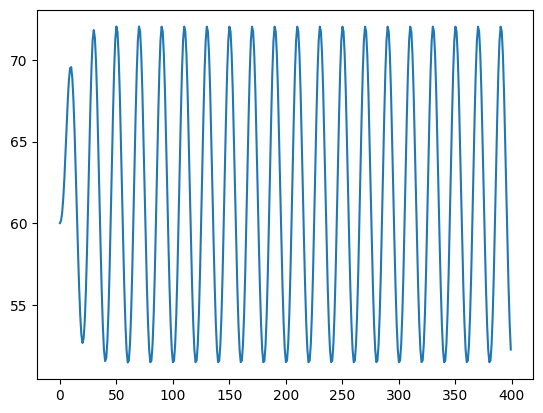

In [6]:
plt.plot(y[0])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
time = torch.tensor(t).to(device)

In [16]:
h_t_ = torch.tensor(h_t, dtype=torch.float64)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
train = torch.stack((torch.div(h_t_, 1000.),torch.div(y_0_, 1000.), y_1_)).to(device)

In [17]:
train = train.transpose(0,1)

In [18]:
train.shape

torch.Size([400, 3])

In [277]:
anode = ODENet(device, data_dim=3, hidden_dim=64, augment_dim=1)
optimizer = torch.optim.Adam(anode.parameters(), lr=1e-3)

In [12]:

MAX_NUM_STEPS = 1000

In [202]:
class ODEFunc(nn.Module):
    """MLP modeling the derivative of ODE system.

    Parameters
    ----------
    device : torch.device

    data_dim : int
        Dimension of data.

    hidden_dim : int
        Dimension of hidden layers.

    augment_dim: int
        Dimension of augmentation. If 0 does not augment ODE, otherwise augments
        it with augment_dim dimensions.

    time_dependent : bool
        If True adds time as input, making ODE time dependent.

    non_linearity : string
        One of 'relu' and 'softplus'
    """
    def __init__(self, device, data_dim, hidden_dim, augment_dim=0,
                 time_dependent=False, non_linearity='relu'):
        super(ODEFunc, self).__init__()
        self.device = device
        self.augment_dim = augment_dim
        self.data_dim = data_dim
        self.input_dim = data_dim + augment_dim
        self.hidden_dim = hidden_dim
        self.nfe = 0  # Number of function evaluations
        self.time_dependent = time_dependent

        if time_dependent:
            self.fc1 = nn.Linear(self.input_dim + 1, hidden_dim)
        else:
            self.fc1 = nn.Linear(self.input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, self.input_dim)

        if non_linearity == 'relu':
            self.non_linearity = nn.ReLU(inplace=True)
        elif non_linearity == 'softplus':
            self.non_linearity = nn.Softplus()

    def forward(self, t, x):
        """
        Parameters
        ----------
        t : torch.Tensor
            Current time. Shape (1,).

        x : torch.Tensor
            Shape (batch_size, input_dim)
        """
        # Forward pass of model corresponds to one function evaluation, so
        # increment counter
        self.nfe += 1
        if self.time_dependent:
            # Shape (batch_size, 1)
            t_vec = torch.ones(x.shape[0], 1).to(self.device) * t
            # Shape (batch_size, data_dim + 1)
            t_and_x = torch.cat([t_vec, x], 1)
            # Shape (batch_size, hidden_dim)
            out = self.fc1(t_and_x)
        else:
            out = self.fc1(x)
        out = self.non_linearity(out)
        out = self.fc2(out)
        out = self.non_linearity(out)
        out = self.fc3(out)
        return out


class ODEBlock(nn.Module):
    """Solves ODE defined by odefunc.

    Parameters
    ----------
    device : torch.device

    odefunc : ODEFunc instance or anode.conv_models.ConvODEFunc instance
        Function defining dynamics of system.

    is_conv : bool
        If True, treats odefunc as a convolutional model.

    tol : float
        Error tolerance.

    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    """
    def __init__(self, device, odefunc, tol=1e-3, adjoint=False):
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.device = device
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, eval_times=None):
        """Solves ODE starting from x.

        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, self.odefunc.data_dim)

        eval_times : None or torch.Tensor
            If None, returns solution of ODE at final time t=1. If torch.Tensor
            then returns full ODE trajectory evaluated at points in eval_times.
        """
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0

        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)


        if self.odefunc.augment_dim > 0:
           
            # Add augmentation
            aug = torch.zeros(x.shape[0], self.odefunc.augment_dim).to(self.device)
            # Shape (batch_size, data_dim + augment_dim)
            x_aug = torch.cat([x, aug], 1)
        else:
            x_aug = x

        if self.adjoint:
            out = odeint_adjoint(self.odefunc, x_aug, integration_time,
                                 rtol=self.tol, atol=self.tol, method='dopri5',
                                 options={'max_num_steps': MAX_NUM_STEPS})
        else:
            #print(x_aug.shape)
            out = odeint(self.odefunc, x_aug, integration_time,
                         rtol=self.tol, atol=self.tol, method='dopri5',
                         options={'max_num_steps': MAX_NUM_STEPS})

        if eval_times is None:
            return out[1]  # Return only final time
        else:
            return out

    def trajectory(self, x, timesteps):
        """Returns ODE trajectory.

        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, self.odefunc.data_dim)

        timesteps : int
            Number of timesteps in trajectory.
        """
        integration_time = torch.linspace(0., 1., timesteps)
        return self.forward(x, eval_times=integration_time)


class ODENet(nn.Module):
    """An ODEBlock followed by a Linear layer.

    Parameters
    ----------
    device : torch.device

    data_dim : int
        Dimension of data.

    hidden_dim : int
        Dimension of hidden layers.

    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.

    augment_dim: int
        Dimension of augmentation. If 0 does not augment ODE, otherwise augments
        it with augment_dim dimensions.

    time_dependent : bool
        If True adds time as input, making ODE time dependent.

    non_linearity : string
        One of 'relu' and 'softplus'

    tol : float
        Error tolerance.

    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    """
    def __init__(self, device, data_dim, hidden_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu',
                 tol=1e-3, adjoint=False):
        super(ODENet, self).__init__()
        self.device = device
        self.data_dim = data_dim
        self.hidden_dim = hidden_dim
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol

        odefunc = ODEFunc(device, data_dim, hidden_dim, augment_dim,
                          time_dependent, non_linearity)

        self.odeblock = ODEBlock(device, odefunc, tol=tol, adjoint=adjoint)
        self.linear_layer = nn.Linear(self.odeblock.odefunc.input_dim,
                                      self.output_dim)

    def forward(self, x, return_features=False):
        features = self.odeblock(x)
        pred = self.linear_layer(features)
        if return_features:
            return features, pred
        return pred

In [21]:
epochs = 1000

In [40]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(4, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,4)
        self.elu = nn.ELU()
        

    def forward(self, t,x):
        x = self.elu(self.lin(x))
        x = self.elu(self.lin2(x))
        x = self.elu(self.lin3(x))
        x = self.lin4(x)
        return x
     

In [14]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [62]:
anode = DWODE().double().to(device)
optimizer = torch.optim.Adagrad(anode.parameters(), lr=1e-3)

Iter 0900 | Total Loss 0.003317


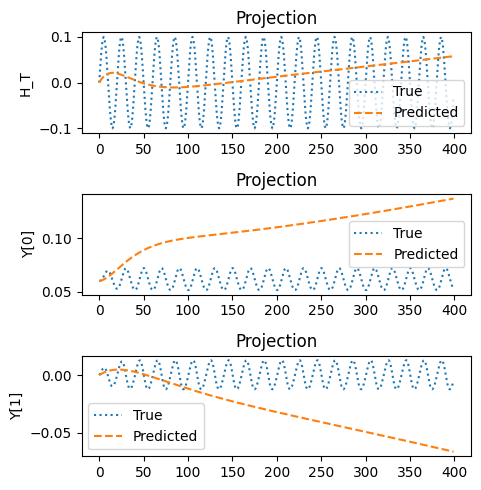

In [63]:
losses = []
whole_losses = []
for i in range(epochs):          
            optimizer.zero_grad()
            x,t,y = get_batch(train,8)
            x = x.to(device)
            y = y.to(device)
            t = t.to(device)
            aug = torch.zeros(x.shape[0], 1).to(device)
            # Shape (batch_size, data_dim + augment_dim)
            x_aug = torch.cat([x, aug], 1)
            y_pred = odeint_adjoint(anode,x_aug,t,method='dopri5' )
            y_pred = y_pred[:,:,:3]
            # print('y_pred shape:',y_pred.shape)
            # print(y.shape)
            #print('y_pred',y_pred)
            #print('y',y)
            loss = F.mse_loss(y_pred, y)
            #print('loss:',loss)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())  
            if i % 100 == 0:
                with torch.no_grad():
                    init = train[0].reshape(1,-1)
                    aug = torch.zeros(init.shape[0], 1).to(device)

                    x_aug = torch.cat([init, aug], 1)
                    pred_y = odeint_adjoint(anode,x_aug,time,method='dopri5')
                    pred_y = pred_y[:,:,:3]
                    #print('pred_y',pred_y.shape)
                    l = train.reshape(400,1,3)
                    loss = F.mse_loss(pred_y, l)
                    whole_losses.append(loss.item()) 
                    print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
                    x_pred = pred_y[:,:,0].cpu()
                    y_pred = pred_y[:,:,1].cpu()
                    z_pred = pred_y[:,:,2].cpu()

                    # Extract the x, y, z coordinates from X_train_plt
                    x_train = train[:,0].cpu()
                    y_train = train[:,1].cpu()
                    z_train = train[:,2].cpu()

                    fig, ax = plt.subplots(3, 1, figsize=(5, 5))
                    ax[0].plot(x_train, label='True',linestyle=':')
                    ax[0].plot(x_pred, label='Predicted', linestyle='--')
                    ax[0].set_ylabel('H_T')
                    ax[0].set_title('Projection')
                    ax[0].legend()

                    ax[1].plot(y_train, label='True',linestyle=':')
                    ax[1].plot(y_pred, label='Predicted',linestyle='--')
                    ax[1].set_ylabel('Y[0]')
                    ax[1].set_title('Projection')
                    ax[1].legend()

                    ax[2].plot(z_train, label='True',linestyle=':')
                    ax[2].plot(z_pred, label='Predicted',linestyle='--')
                    ax[2].set_ylabel('Y[1]')
                    
                    ax[2].set_title('Projection')
                    ax[2].legend()

                    plt.tight_layout()
                    plt.show()
                    clear_output(wait=True)

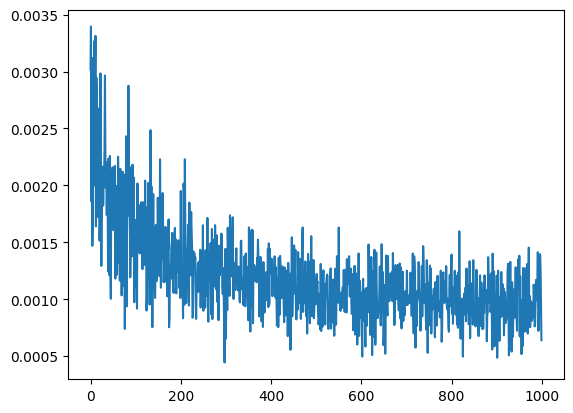

In [64]:
plt.plot(losses)
plt.show()

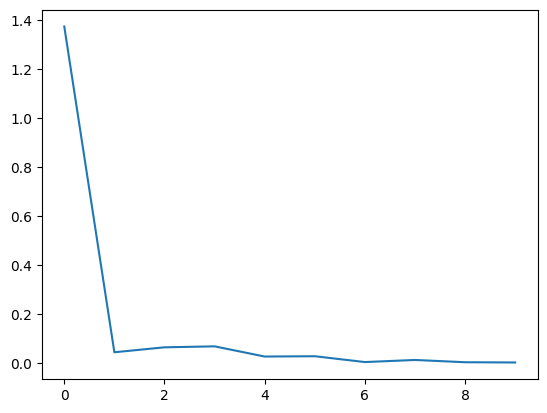

In [65]:
plt.plot(whole_losses)
plt.show()

In [66]:
with torch.no_grad():
    init = train[0].reshape(1,-1)
    aug = torch.zeros(init.shape[0], 1).to(device)

    x_aug = torch.cat([init, aug], 1)
    pred_y = odeint_adjoint(anode,x_aug,time)
    pred_y = pred_y[:,:,:3]

In [67]:
pred = pred_y.cpu().detach().numpy()

In [47]:
pred.shape

(400, 1, 3)

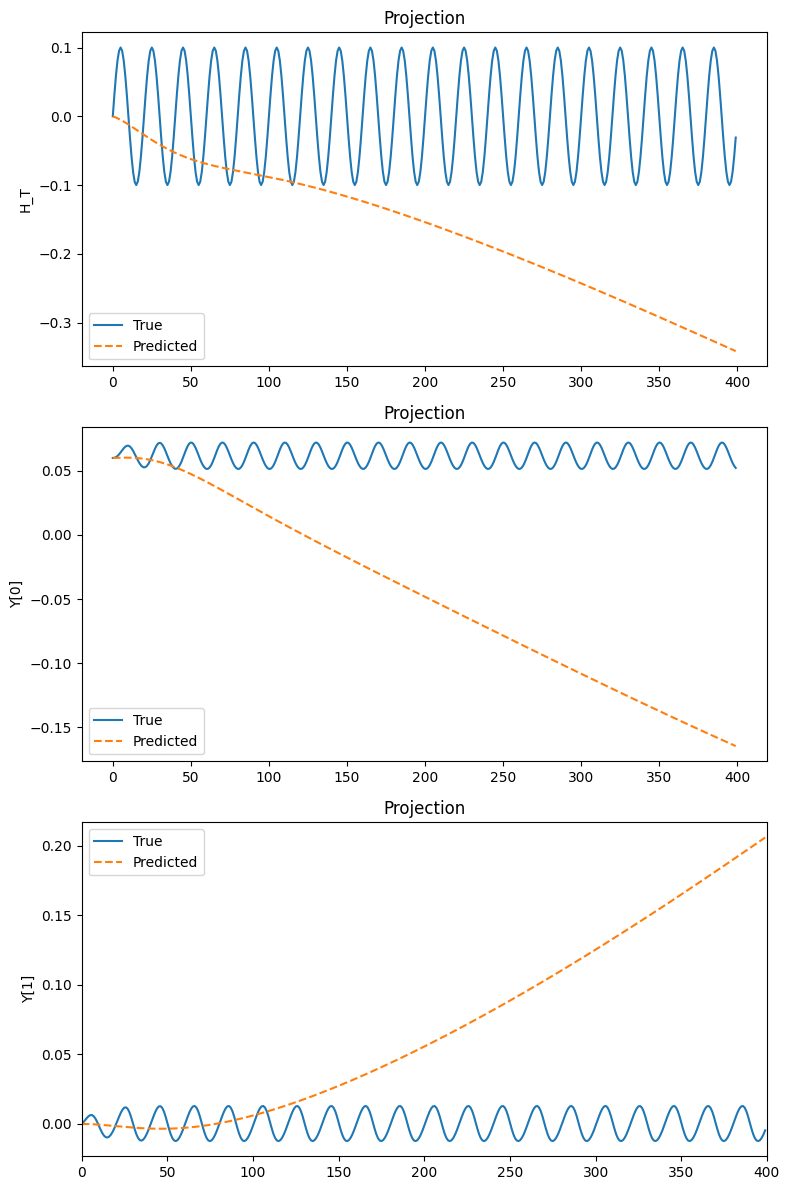

In [68]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,:,0]
y_pred = pred[:,:,1]
z_pred = pred[:,:,2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()
z_train = train[:,2].cpu()

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
# ax[0].set_xlim(0, 200)
# ax[0].set_ylim(0, 300)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Y[1]')
ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()
plt.savefig('projection_max_steps.png')
plt.tight_layout()
plt.show()